# SWYFT tutorial

This tutorial highlights three aspects of *swyft*.

- The general *swyft* API. It is somewhat verbose right now, but will be stream-lined in the future.
- For simple problems like linear regression *swyft* reproduces known results.
- Solving hard problems, like the marginalization over a high-dimensional nuiscance parameter space with $10^{18}$ modes, becomes (almost) as simple as linear regression.


In [3]:
# DON'T FORGET TO ACTIVATE THE GPU when on google colab (Edit > Notebook settings)

## Imports

In [4]:
# Install swyft when on google colab
from os import environ
GOOGLE_COLAB = True if "COLAB_GPU" in environ else False
if GOOGLE_COLAB:
    !pip install git+https://github.com/undark-lab/swyft.git

In [9]:
# Standard imports
import numpy as np
import pylab as plt
from scipy import stats
import torch

# Set randomness
np.random.seed(25)
torch.manual_seed(25)

# Import swyft
import swyft
DEVICE = 'cuda'

### Image model

In [10]:
prior = swyft.Prior.from_uv(lambda u: u*np.array([1., 1., 0.5]), 3)

In [11]:
def simulator(v, w = 0.03):
    "Ring simulator"
    x1, y1, r = v
    
    grid = np.linspace(0, 1, 32, 32)
    X, Y = np.meshgrid(grid, grid)
    
    R1 = ((X-x1)**2 + (Y-y1)**2)**0.5
    mu = np.exp(-(R1-r)**2/w**2/2)
    
    # Add random distortions in terms of lines
    for _ in range(20):
        xr = np.random.rand(2)
        mu += 0.8*np.exp(-(X*xr[0]+Y*(1-xr[0])-xr[1])**2/0.01**2)
        
    return dict(x=np.array(mu))

def noise(obs, v, sigma=0.1):
    mu = obs['x']
    n = np.random.randn(*mu.shape)*sigma
    x = mu + n
    return dict(x=x)

We add some random very non-Gaussian noise (random straight lines) to make things more interesting.  Analyzing such an image with likelihood-based methods would introduce 40 extra nuisance parameters.  The traditional approach would be to generate samples from the 43-dim posterior, which significnatly complicates estimates of the ring parameters.  In *swyft*, we can instead just ignore those parameters, this is enough to marginalize them out.

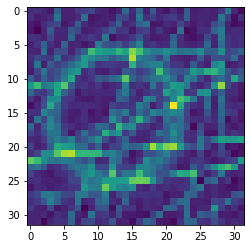

In [13]:
v0 = np.array([0.4, 0.5, 0.3])
mu0 = simulator(v0)
obs0 = noise(mu0, v0)
plt.imshow(obs0['x']);

In [14]:
sim = swyft.Simulator(simulator, sim_shapes = dict(x=(32, 32)))

In [15]:
store = swyft.MemoryStore(3, simulator = sim)

Creating new store.


### Head network

We write a simple convolutional neural network as head network. The `forward` method has to take as input the data, and output a single vector. The network has to be written such that it can be batched.

In [16]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 160
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([32,32]))
        self.conv1 = torch.nn.Conv2d(1, 10, 3)
        self.conv2 = torch.nn.Conv2d(10, 20, 3)
        self.conv3 = torch.nn.Conv2d(20, 40, 3)
        self.pool = torch.nn.MaxPool2d(2)

    def forward(self, obs):
        x=obs['x']
        x = self.onl_f(x)
        
        nbatch = len(x)
        
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = x.view(nbatch, -1)

        return x

### Running the analysis

Analysing the image is now simple. We just provide an instance of the `Head` network as argument to `NestedRatios.run` and `NestedRatios.gen_1d_marginals` . That's it.

In [17]:
dataset = swyft.Dataset(10000, prior, simhook = noise, store = store)
dataset.simulate()

Store: Adding 10104 new samples to simulator store.
Simulator: Running...
Simulator: ...done.


In [18]:
post = swyft.Posteriors(dataset)

In [19]:
marginals = [0, 1, 2]
post.add(marginals, device = DEVICE, head = Head)
post.train(marginals)

Training: lr=0.001, Epoch=8, VL=1.988
Training: lr=0.0003, Epoch=2, VL=1.954
Training: lr=0.0001, Epoch=5, VL=1.772


### 1-dim posteriors for reference image

And voila. The posteriors estimated by the network agree well with the input parameters.

In [20]:
samples=post.sample(100000, obs0)

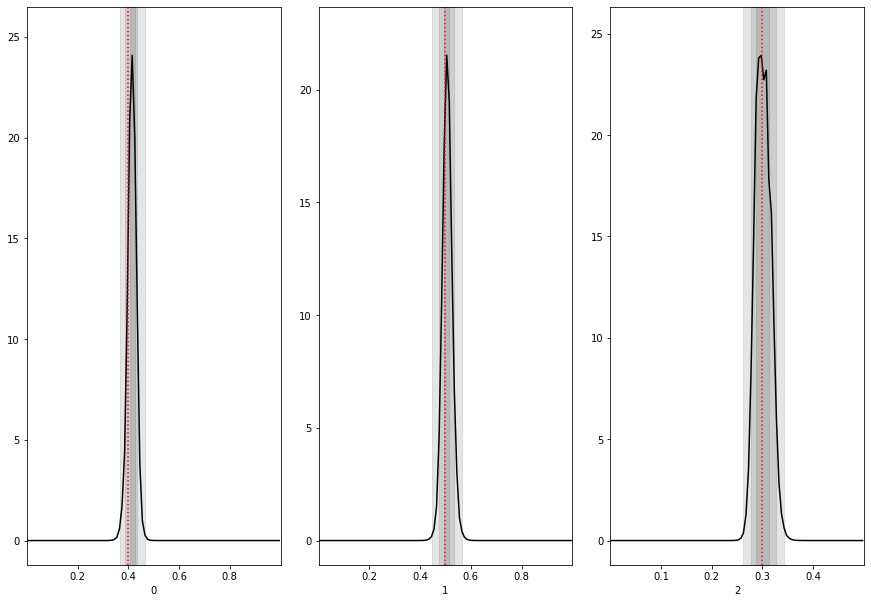

In [21]:
swyft.plot1d(samples, [0, 1, 2], truth = v0)

### Amortised posteriors

Since we only trained the network for one round - on the full model parameter space, we can actually also quickly generate posteriors for other images. This comes at no extra costs, since the network amortised all possible posteriors.

In [22]:
def plot_posterior(i):
    obs, u = dataset[i]
    plt.imshow(obs['x'])
    samples=post.sample(100000, obs)
    v = prior.ptrans.v(u.reshape(1,-1))[0]
    swyft.plot1d(samples, [0, 1, 2], truth=v)

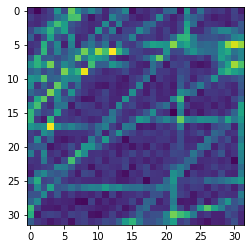

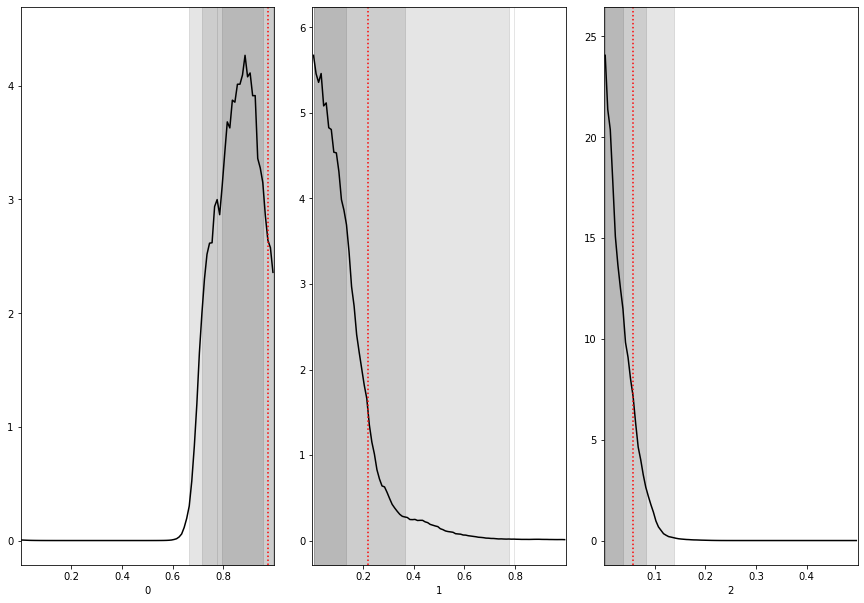

In [23]:
plot_posterior(0)

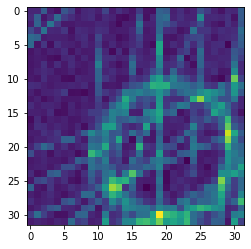

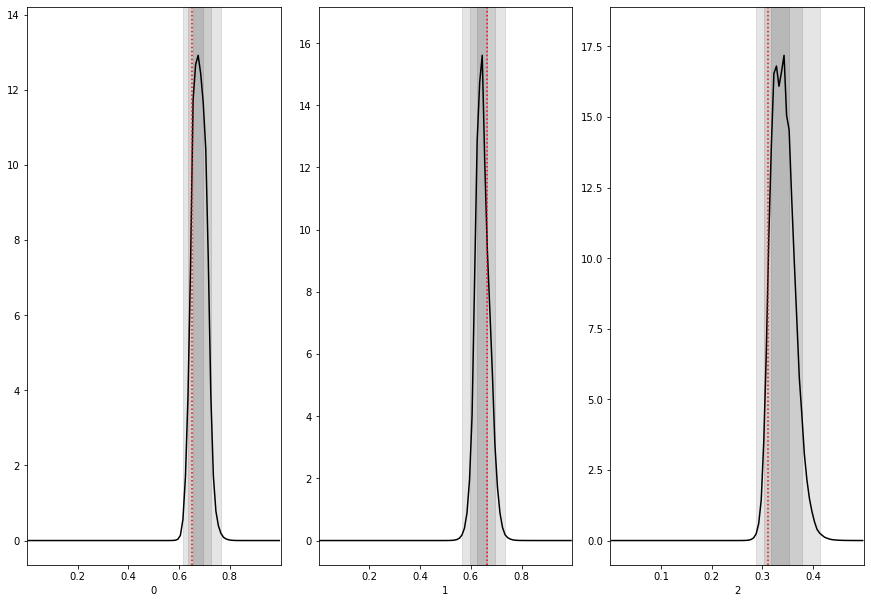

In [24]:
plot_posterior(1)

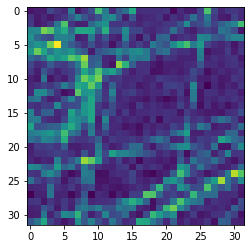

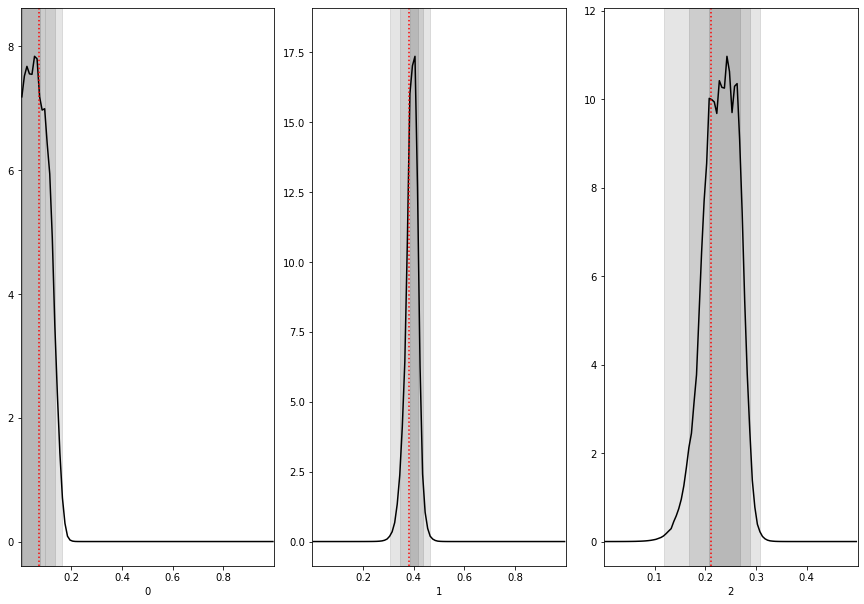

In [25]:
plot_posterior(2)

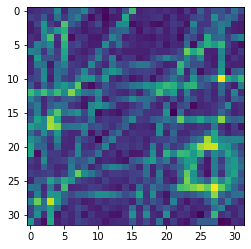

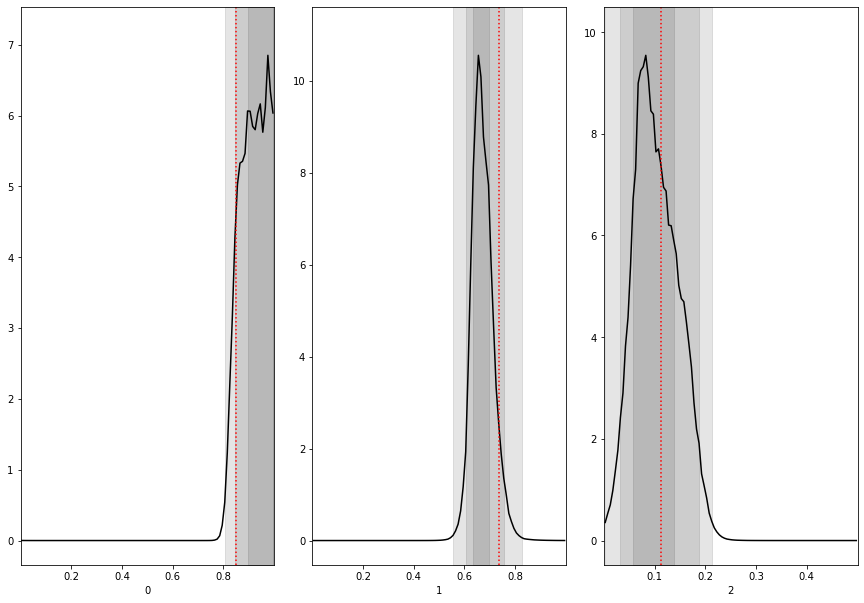

In [26]:
plot_posterior(3)

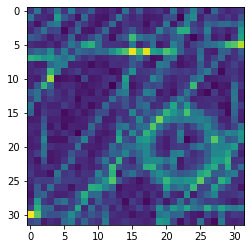

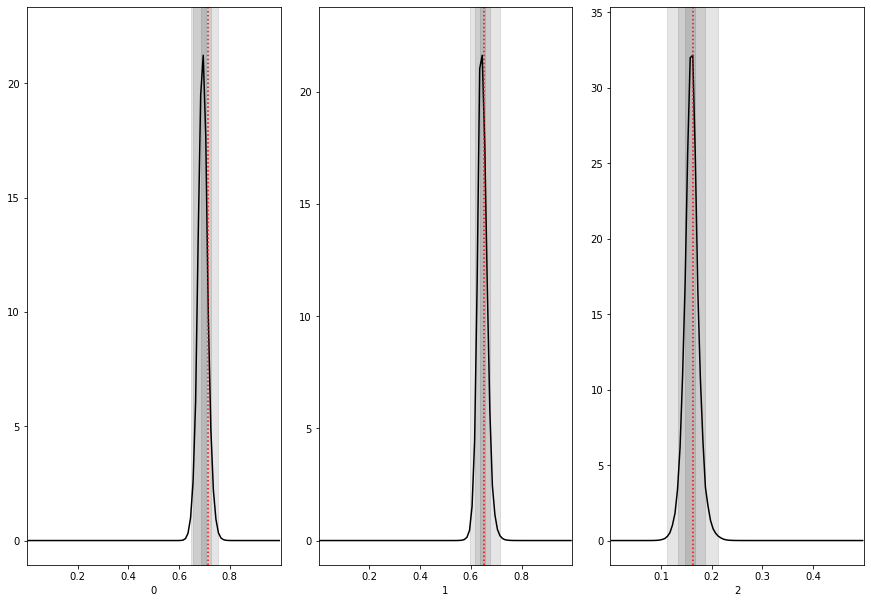

In [27]:
plot_posterior(4)

In [28]:
marginals_2d = [(0, 1), (0, 2), (1, 2)]
post.add(marginals_2d, device = DEVICE, head = Head)
post.train(marginals_2d)

Training: lr=0.001, Epoch=7, VL=1.398
Training: lr=0.0003, Epoch=2, VL=1.145
Training: lr=0.0001, Epoch=3, VL=1.068


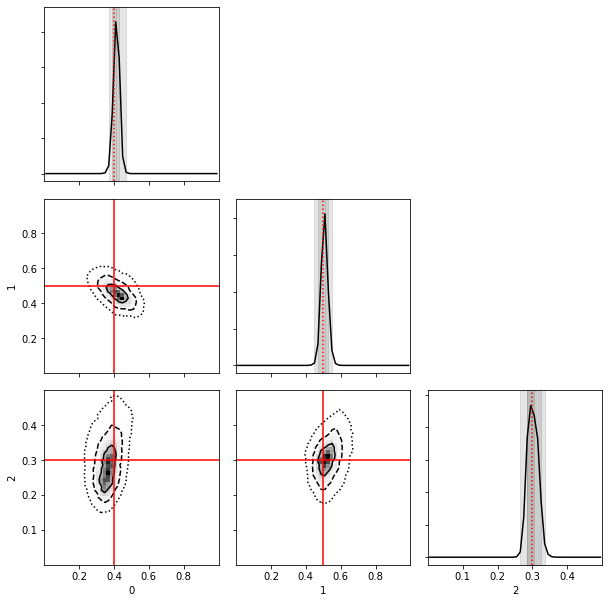

In [29]:
samples = post.sample(100000, obs0)
swyft.corner(samples, [0, 1, 2], truth = v0, bins = 50)

## Some final words - Unleashing the power of marginal posterior estimation

- It is notable that the last results are obtained with just 5000 training images and a very simple head network.  At the same time, obtaining similar results - even for a single image - with a pure likelihood-based approach would be rediciously challenging, since the full joint 43-dim posterior that would have to be explored has ~$10^{18}$ modes (the lines are permutation symmetric, which gives a factor $20!$).
- We note that more training data or a more expressive head network would potentially improve the quality of the results.
- More information about the underlying theory and the code structure can be found on https://swyft.readthedocs.io/en/latest/, as well as the papers that are referenced there.